Here we import the functions from your implementation. This will generate the same plots as in the implementation notebook.

**Note:** If you compute large amounts of Pareto fronts, this will result in long computation times.

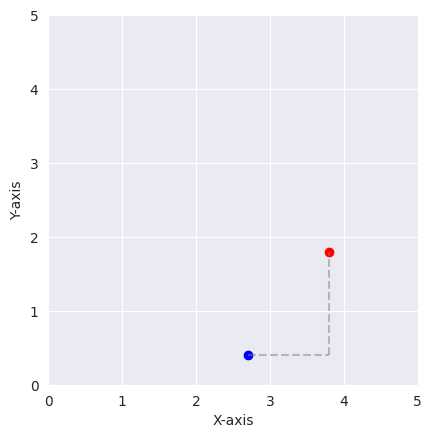

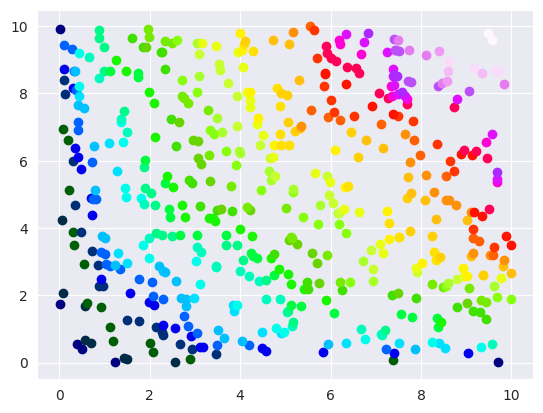

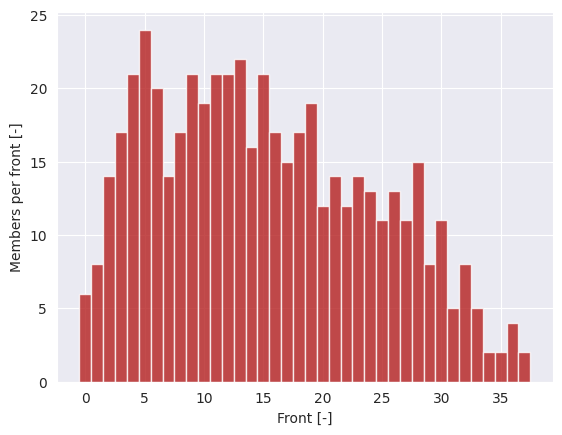

In [1]:
# Surpresses printing from other notebook
import io
import sys

original_stdout = sys.stdout
sys.stdout = io.StringIO()
%run nsga-ii-solutions.ipynb
sys.stdout = original_stdout

# Beam optimization

In this exercise, we will use multi-objective optimization to find the optimal beam parameters considering weight and deflection. For optimization, we will use the Non-dominating Sorting Genetic Algorithm II.

<img src="assets/charles_kuonen_bridge.jpg" width="640">

# Imports

In [2]:
from tqdm.notebook import tqdm
import random

## Beam Modeling

NSGA-II can be used to solve a multivariate, multi-objective optimization problems. For instance, here the objective is to minimize two objectives, a beam’s weight and deflection (functions `f_weight` and `f_deflection`), by finding a good combination of two variables, the beam's diameter, $d$, and length, $l$. 

When you run the code below, NSGA-II will look for a good solution for the two objectives. 

While setting up the optimisation algorithm, the user will have an idea about the possible range of each variable ($d$ and $l$). For instance, here the diameter can be between $0.01 m$ and $0.05 m$ while the length can be between $0.2 m$ and $1.0 m$. 

## Exercise 4

- 4.1. Run the code below and observe the results you get from this type of genetic algorithm. What is the benefit of obtaining the first Pareto front rather than a single optimal solution?
- 4.2. Try different values of `density`, `F_ext` and `E`. How does this affect the first Pareto front? 
- 4.3. In the next block of code, "Constraint handling", try changing the the maximum stress and see how this changes the subset of the first Pareto front that the designer can choose from.

In [3]:
density = 7800 # [kg/m^3] density of beam
F_ext = 2000 # [N] force applied to the end of the beam 
E = 207e9 # [Pa] young's modulus of beam

def f_weight(diameter, length):
    # minimize weight
    return density * length * np.pi * diameter**2 / 4.0


def f_deflection(diameter, length):
    # minimize deflection
    return 64.0 * F_ext * length**3 / (3.0 * E * np.pi * diameter**4)

# Parameter constraints
## d between 0.01 m and 0.05 m
## l between 0.2 m and 1.0 m
value_ranges = [(0.01, 0.05), (0.2, 1.0)]

## Run evolution

In [4]:
## Objective functions
objective_functions = [f_weight, f_deflection]

# Algorithm parameters
num_generations = 100
population_size = 200
num_parameters = 2
tournament_size = 2

crossover_parameter = 2
crossover_probability = 0.1

mutation_factor = 20
mutation_probability = 0.5

# User sanity check
assert population_size % 2 == 0
assert len(value_ranges) == num_parameters


# Get initial population
population = initialise_population(population_size, num_parameters, value_ranges)

for gen in tqdm(range(num_generations)):
    # Evaluate fitness and Pareto fronts from population
    fitness = evaluate_population(population, objective_functions)
    pareto_fronts, front_membership = fast_nondominated_sort(fitness)

    # Select now the members of the best fronts for our new population and cut fronts
    # which exceed half of the population size.
    selected_population = []
    selected_population_crowding_distance = []
    selected_population_front_membership = []
    
    num_fronts = 0
    while len(selected_population) + len(pareto_fronts[num_fronts]) < int(population_size/2):
        current_front = pareto_fronts[num_fronts]
        
        # compute crowding distance for every front
        crowding_distances = compute_crowding_distance(fitness, current_front)
        
        for front_index, population_index in enumerate(current_front):
            selected_population.append(population[population_index, :])
            selected_population_front_membership.append(num_fronts)
            selected_population_crowding_distance.append(crowding_distances[front_index])
            
        num_fronts += 1
    
    # Select the members with the highest crowding distances for our new population.
    num_open_slots = int(population_size/2) - len(selected_population)
    
    # Add crowding distance of splitted front
    crowding_distances = compute_crowding_distance(fitness, pareto_fronts[num_fronts])
    crowding_rank = np.argsort(crowding_distances)[::-1]
    
    for i in range(num_open_slots):
        candidate = crowding_rank[i]
        
        population_index = pareto_fronts[num_fronts][candidate]
        
        selected_population.append(population[population_index, :])
        selected_population_crowding_distance.append(crowding_distances[candidate])
        selected_population_front_membership.append(num_fronts)
    
    # Convert to numpy array
    selected_population = np.array(selected_population)
    
    # Tournament selection, crossover
    new_population = np.zeros((population_size, num_parameters))
    for i in range(int(population_size/2)):
        parent_1_index = tournament_selection(
            selected_population_front_membership,
            selected_population_crowding_distance,
            tournament_size,
        )
        
        parent_2_index = parent_1_index
        
        # ensures that parent 1 is not the same as parent 2
        while parent_1_index == parent_2_index:    
            parent_2_index = tournament_selection(
                selected_population_front_membership,
                selected_population_crowding_distance,
                tournament_size,
            )

        parent_1 = selected_population[parent_1_index, :]
        parent_2 = selected_population[parent_2_index, :]

        child_1, child_2 = stochastic_crossover(parent_1, parent_2, crossover_probability)
        cild_1, child_2 = parent_1, parent_2
        
        new_population[i, :] = child_1
        new_population[i + int(population_size/2), :] = child_2
    
    new_population = mutate_population(new_population, mutation_probability, value_ranges, mutation_factor)
        
    # generational change
    population = new_population

fitness = evaluate_population(selected_population, objective_functions)
pareto_fronts, front_membership = fast_nondominated_sort(fitness)

  0%|          | 0/100 [00:00<?, ?it/s]

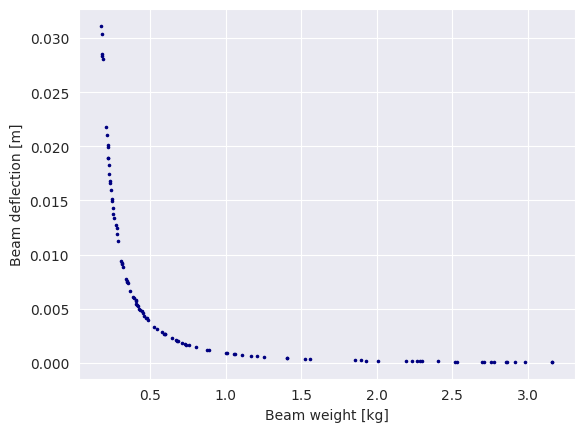

In [5]:
fig, ax = plt.subplots()
color_map = plt.cm.gist_ncar(np.linspace(0, 1, len(pareto_fronts)))
for i, front in enumerate(pareto_fronts):
    values = fitness[front]
    ax.scatter(values[:, 0], values[:, 1], color=color_map[i], s=2.5)
    
ax.set_xlabel("Beam weight [kg]")
ax.set_ylabel("Beam deflection [m]")

plt.show()

## First Pareto front

The plotted points represent identified solutions, with the blue points illustrating the primary Pareto front. This signifies that these solutions are undominated by any others, placing them within a tier of equally optimal solutions; there is no single best solution among them. This scenario arises from our objective to minimize two factors simultaneously. As demonstrated, decreasing deflection leads to an increase in weight, and conversely, lowering weight results in higher deflection.

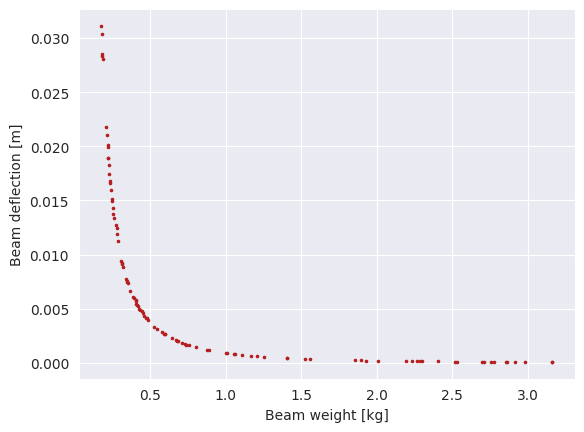

In [6]:
fig, ax = plt.subplots()

values = fitness[pareto_fronts[0]]
ax.scatter(values[:, 0], values[:, 1], color="#B51F1F", s=2.5)
    
ax.set_xlabel("Beam weight [kg]")
ax.set_ylabel("Beam deflection [m]")

plt.show()

## Constraint handling

But then how does the designer choose from this set of good solutions? The choice can be narrowed down by looking at the constraints such as maximum stress and maximum deflection of the beam. If the maximum stress is 300 MPa and the maximum deflection is 0.005 m then we can use these to eliminate some of the first Pareto front solutions. 

Run the code below:

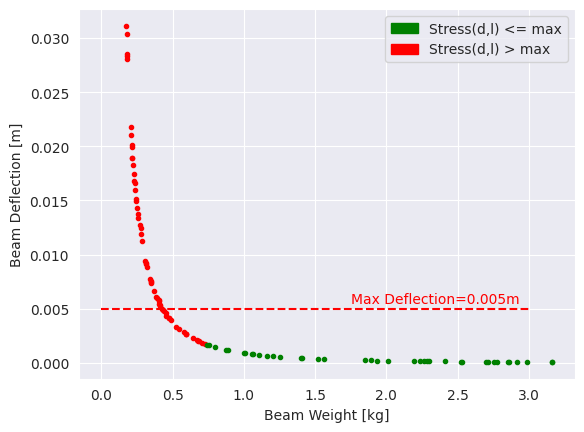

In [7]:
import matplotlib.patches as mpatches

S_y = 300e6 # [Pa] # maximum stress
DELTA_MAX = 0.005 # [m] maximum deflection

def stress(d, l):
    return 32. * F_ext * l / (np.pi * d**3)

plt.xlabel('Beam Weight [kg]')
plt.ylabel('Beam Deflection [m]')
plt.plot([0, 3],[DELTA_MAX, DELTA_MAX], '--r')
plt.text(1.75, DELTA_MAX*1.1, f'Max Deflection={DELTA_MAX}m', color='r')

# check max stress constraint. max stress <= S_y
for i in range(len(selected_population)):
    diameter = selected_population[i][0]
    length = selected_population[i][1]
    values = fitness[pareto_fronts[0]]
    
    if stress(diameter, length) > S_y:
        plt.plot(values[i, 0], values[i, 1], '.r')
    else:
        plt.plot(values[i, 0], values[i, 1], '.g')
        
g_patch = mpatches.Patch(color='g', hatch=".", label='Stress(d,l) <= max')
r_patch = mpatches.Patch(color='r', hatch=".", label='Stress(d,l) > max')
plt.legend(handles=[g_patch, r_patch])
# plt.scatter(function1, function2)
plt.show()

In the above code, we first calculated the stress in the beam for each pair of variables in the first Pareto front. The stresses were compared with the maximum stress and coloured red if they are greater. The maximum deflection was also plotted as the red dashed line. All solutions that met the stress requirements also met the deflection requirements and are coloured green. 


# Zoomed in

Zooming in to the 2-objective Pareto front in the desirable stress region (green), we can see that there is still not a single optimal combination of the diameter and length of the beam. Although the deflection difference is small, there is still a trade-off between reducing the deflection and increasing the weight of the beam.

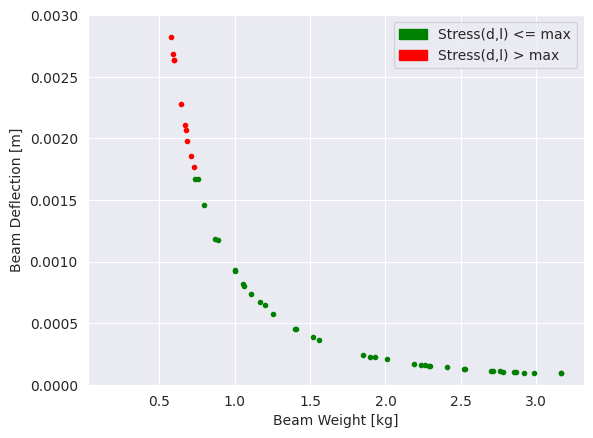

In [8]:
import matplotlib.patches as mpatches

S_y = 300e6 # [Pa] # maximum stress
DELTA_MAX = 0.005 # [m] maximum deflection

def stress(d, l):
    return 32. * F_ext * l / (np.pi * d**3)

# check max stress constraint. max stress <= S_y
for i in range(len(selected_population)):
    diameter = selected_population[i][0]
    length = selected_population[i][1]
    values = fitness[pareto_fronts[0]]
    
    if stress(diameter, length) > S_y:
        plt.plot(values[i, 0], values[i, 1], '.r')
    else:
        plt.plot(values[i, 0], values[i, 1], '.g')
        
g_patch = mpatches.Patch(color='g', hatch=".", label='Stress(d,l) <= max')
r_patch = mpatches.Patch(color='r', hatch=".", label='Stress(d,l) > max')

plt.legend(handles=[g_patch, r_patch])
plt.ylim([0,0.003])
plt.xlabel('Beam Weight [kg]')
plt.ylabel('Beam Deflection [m]')
# plt.scatter(function1, function2)
plt.show()